In [7]:
#!wget http://cogcomp.org/Data/QA/QC/train_5500.label
!wget http://cogcomp.org/Data/QA/QC/TREC_10.label

--2018-09-20 10:39:29--  http://cogcomp.org/Data/QA/QC/TREC_10.label
Resolving cogcomp.org... 192.17.58.140
Connecting to cogcomp.org|192.17.58.140|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23354 (23K) [text/plain]
Saving to: 'TREC_10.label'

TREC_10.label       100%[=====================>]  22.81K  --.-KB/s   in 0.1s   

2018-09-20 10:39:29 (166 KB/s) - 'TREC_10.label' saved [23354/23354]



## Read data

In [67]:
def read_file(f): 
    labels, texts = [], []
    with open(f, encoding="latin-1") as i:
        for line in i:
            line = line.strip().split()
            label = line[0]
            text = " ".join(line[1:])
            labels.append(label)
            texts.append(text)
    return texts, labels
    
train_texts, train_labels = read_file("train_5500.label")
test_texts, test_labels = read_file("TREC_10.label")

print("Found", len(train_texts), "training texts")
print("Found", len(test_texts), "test texts")

Found 5452 training texts
Found 500 test texts


## Build a classifier

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

baseline = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3), min_df=2)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 3), min_df=2)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(C=10.0)),
])


In [80]:
baseline.fit(train_texts, train_labels)
logreg.fit(train_texts, train_labels)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

## Testing and evaluation

In [81]:
predictions_baseline = baseline.predict(test_texts)
predictions_logreg = logreg.predict(test_texts)

stop = 10
for (text, pred_label, gold_label) in zip(test_texts[:stop], predictions_baseline[:stop], test_labels[:stop]):
    print(text, pred_label, gold_label)
    

How far is it from Denver to Aspen ? NUM:count NUM:dist
What county is Modesto , California in ? LOC:other LOC:city
Who was Galileo ? HUM:ind HUM:desc
What is an atom ? DESC:def DESC:def
When did Hawaii become a state ? NUM:date NUM:date
How tall is the Sears Building ? LOC:other NUM:dist
George Bush purchased a small interest in which baseball team ? HUM:ind HUM:gr
What is Australia 's national flower ? DESC:def ENTY:plant
Why does the moon turn orange ? DESC:def DESC:reason
What is autism ? DESC:def DESC:def


In [82]:
import numpy as np

print("Baseline accuracy:", np.mean(predictions_baseline == test_labels))
print("LogReg accuracy:", np.mean(predictions_logreg == test_labels))

Baseline accuracy: 0.574
LogReg accuracy: 0.79


In [60]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions_logreg))

                precision    recall  f1-score   support

      ABBR:abb       0.00      0.00      0.00         1
      ABBR:exp       0.83      0.62      0.71         8
      DESC:def       0.62      1.00      0.77       123
     DESC:desc       0.33      0.43      0.38         7
   DESC:manner       0.12      1.00      0.22         2
   DESC:reason       1.00      0.83      0.91         6
   ENTY:animal       1.00      0.25      0.40        16
     ENTY:body       0.00      0.00      0.00         2
    ENTY:color       1.00      0.50      0.67        10
 ENTY:currency       0.00      0.00      0.00         6
   ENTY:dismed       0.00      0.00      0.00         2
    ENTY:event       0.00      0.00      0.00         2
     ENTY:food       1.00      0.25      0.40         4
   ENTY:instru       0.00      0.00      0.00         1
     ENTY:lang       1.00      0.50      0.67         2
    ENTY:other       0.29      0.17      0.21        12
    ENTY:plant       0.00      0.00      0.00  

/Users/yvespeirsman/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_labels, predictions_logreg))

[[  0   1   0 ...   0   0   0]
 [  0   5   3 ...   0   0   0]
 [  0   0 123 ...   0   0   0]
 ...
 [  0   0   2 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 [  0   0   2 ...   0   0   0]]


Confusion matrix, without normalization
[[  0   1   0 ...   0   0   0]
 [  0   5   3 ...   0   0   0]
 [  0   0 123 ...   0   0   0]
 ...
 [  0   0   2 ...   0   0   0]
 [  0   0   2 ...   0   0   0]
 [  0   0   2 ...   0   0   0]]


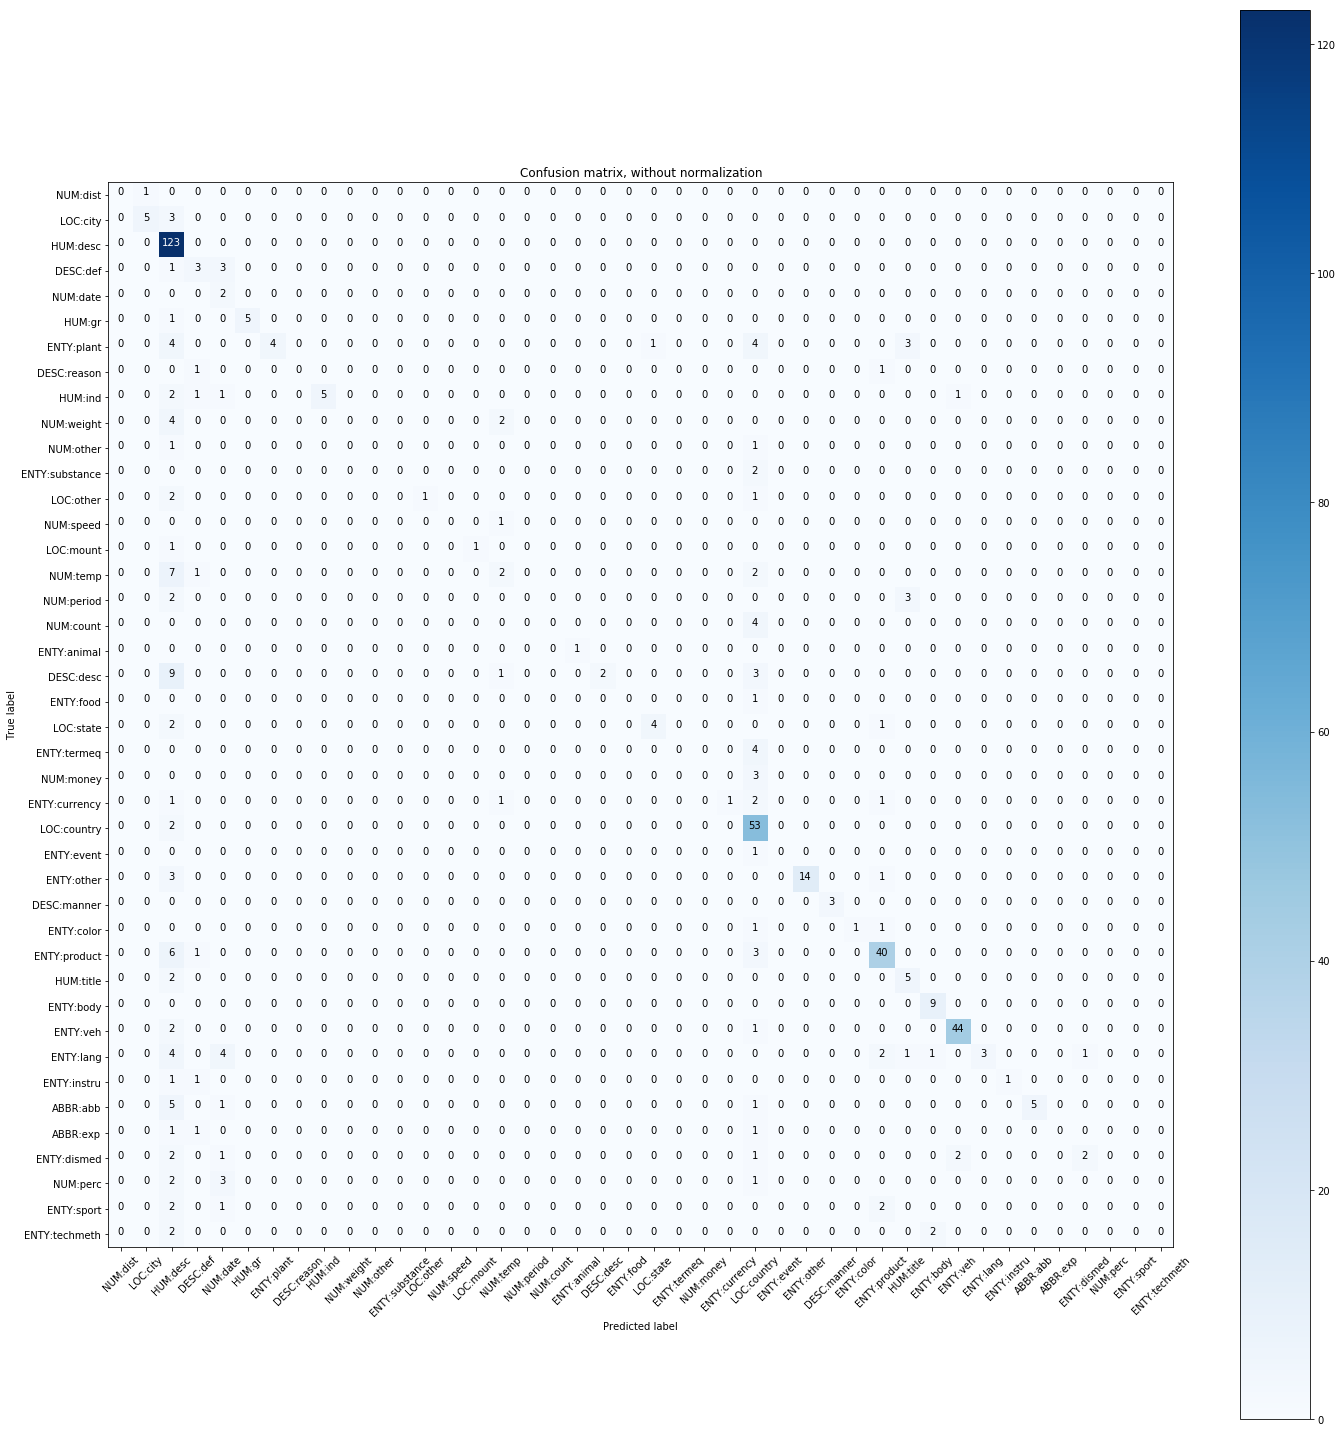

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(test_labels, predictions_logreg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix

def get_class_names(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

plt.rcParams['figure.figsize'] = (20,20)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=get_class_names(test_labels),
                      title='Confusion matrix, without normalization')

plt.show()

## Model persistence

In [54]:
from sklearn.externals import joblib
joblib.dump(logreg, '../models/question_classifier_en.pkl') 

['../models/question_classifier_en.pkl']